# 08 - Quantum Kernel Training for Machine Learning Applications

In [1]:
# This code is from:
# https://qiskit-community.github.io/qiskit-machine-learning/tutorials/08_quantum_kernel_trainer.html

In [2]:
# External imports
from pylab import cm
from sklearn import metrics
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.visualization import circuit_drawer
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.optimizers import SPSA
#from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.datasets import ad_hoc_data

from quantumrings.toolkit.qiskit.machine_learning import QrFidelityQuantumKernel
from quantumrings.toolkit.qiskit.machine_learning import QrTrainableFidelityQuantumKernel

class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

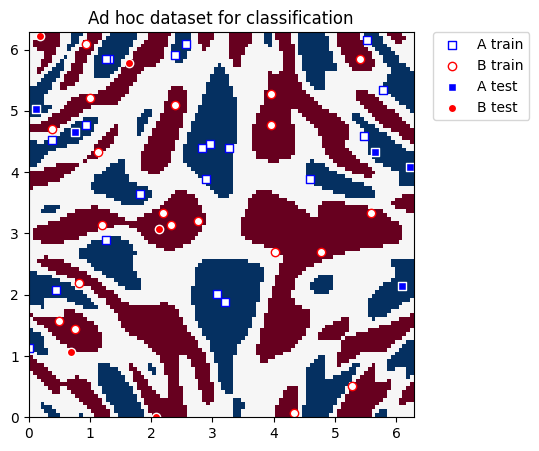

In [3]:
adhoc_dimension = 2
X_train, y_train, X_test, y_test, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

plt.scatter(
    X_train[np.where(y_train[:] == 0), 0],
    X_train[np.where(y_train[:] == 0), 1],
    marker="s",
    facecolors="w",
    edgecolors="b",
    label="A train",
)
plt.scatter(
    X_train[np.where(y_train[:] == 1), 0],
    X_train[np.where(y_train[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="B train",
)
plt.scatter(
    X_test[np.where(y_test[:] == 0), 0],
    X_test[np.where(y_test[:] == 0), 1],
    marker="s",
    facecolors="b",
    edgecolors="w",
    label="A test",
)
plt.scatter(
    X_test[np.where(y_test[:] == 1), 0],
    X_test[np.where(y_test[:] == 1), 1],
    marker="o",
    facecolors="r",
    edgecolors="w",
    label="B test",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset for classification")

plt.show()

In [4]:
# Create a rotational layer to train. We will rotate each qubit the same amount.
training_params = ParameterVector("θ", 1)
fm0 = QuantumCircuit(2)
fm0.ry(training_params[0], 0)
fm0.ry(training_params[0], 1)

# Use ZZFeatureMap to represent input data
fm1 = ZZFeatureMap(2)

# Create the feature map, composed of our two circuits
fm = fm0.compose(fm1)

print(circuit_drawer(fm))
print(f"Trainable parameters: {training_params}")

     ┌──────────┐┌──────────────────────────┐
q_0: ┤ Ry(θ[0]) ├┤0                         ├
     ├──────────┤│  ZZFeatureMap(x[0],x[1]) │
q_1: ┤ Ry(θ[0]) ├┤1                         ├
     └──────────┘└──────────────────────────┘
Trainable parameters: θ, ['θ[0]']


In [5]:
# Instantiate quantum kernel
quant_kernel = QrTrainableFidelityQuantumKernel(feature_map=fm, training_parameters=training_params)

# Set up the optimizer
cb_qkt = QKTCallback()
spsa_opt = SPSA(maxiter=10, callback=cb_qkt.callback, learning_rate=0.05, perturbation=0.05)

# Instantiate a quantum kernel trainer.
qkt = QuantumKernelTrainer(
    quantum_kernel=quant_kernel, loss="svc_loss", optimizer=spsa_opt, initial_point=[np.pi / 2]
)

In [6]:
# Train the kernel using QKT directly
qka_results = qkt.fit(X_train, y_train)
optimized_kernel = qka_results.quantum_kernel
print(qka_results)

{   'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): np.float64(1.8070403308407803)},
    'optimal_point': array([1.80704033]),
    'optimal_value': np.float64(10.753706023903298),
    'optimizer_evals': 30,
    'optimizer_result': None,
    'optimizer_time': None,
    'quantum_kernel': <quantumrings.toolkit.qiskit.machine_learning.qr_trainable_fidelity_quantum_kernel.QrTrainableFidelityQuantumKernel object at 0x0000016FDD6A5250>}
